## <center>Курсовой проект</center>
# <center>Спортивный анализ данных. Платформа Kaggle</center>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from scipy.stats.mstats import gmean
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from pprint import pprint
from tqdm import tqdm
from typing import List, Optional, Tuple

from bayes_opt import BayesianOptimization
from catboost import cv, CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from IPython.display import clear_output, display
from WOE_IV import data_vars

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

Функции с вебинара:

In [2]:
def df_info(df):
    df_display = pd.DataFrame(index=df.columns.copy())
    df_display['isnulls'] = df.isnull().sum()
    df_display['dtypes'] = df.dtypes
    df_display['nuniques'] = df.nunique(dropna=False)
    
    rows, cols = df.shape
    if cols == 1:
        df_display.index.name = '{} rows'.format(rows)
    else:
        df_display.index.name = '{} rows x {} cols'.format(rows, cols)
    
    display(df_display)


def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "geekbrains-competitive-data-analysis"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    # print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()
        
    df_info(X)

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

Константы:

In [3]:
EARLY_STOPPING_ROUNDS = 25
N_ITERATIONS = 1000
VERBOSE = 100
N_SPLITS = 5
SEED = 42

Функция кросс-валидации модели бустинга:

In [4]:
def boost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]      
      
        if boost_model == 'XGB':
            dtrain = xgb.DMatrix(x_train, y_train)
            dvalid = xgb.DMatrix(x_valid, y_valid)
        
            model = xgb.train(
                params=params,
                dtrain=dtrain,
                evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                num_boost_round=N_ITERATIONS,
                verbose_eval=VERBOSE,
                maximize=True,
            )

        elif boost_model == 'LGBM':
            model =LGBMClassifier(**params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=VERBOSE,
                categorical_feature=categorical
            )
        
        elif boost_model == 'CB':
            model = CatBoostClassifier(**params)
            model.fit(
                x_train, y_train,
                cat_features=categorical,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=VERBOSE                
            )
        
        if boost_model == 'XGB':
            oof_preds[valid_idx] = model.predict(dvalid)
        else:
            oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
            
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        if hasattr(model, 'copy'):
            model = model.copy()
        estimators.append(model)
        clear_output(wait=True)

    print(f"Score by each fold: {folds_scores}")

    return estimators, oof_preds

Данные для обучения и теста:

In [5]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0, sort=False)
data = data.reset_index(drop=True)
data.head(n=2)

,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


Данные клиентов:

In [6]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)

,isnulls,dtypes,nuniques
250000 rows x 24 cols,,,
application_number,0,int64,250000
gender,0,object,3
childrens,0,int64,15
total_salary,0,float64,2198
amount_credit,0,float64,5295
amount_annuity,11,float64,13152
education_level,0,object,5
family_status,0,object,6
region_population,0,float64,81


In [7]:
client_profile.head(n=2)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


Склеиваем данные:

In [8]:
data = data.merge(
    client_profile,
    how="left",
    on="application_number"
)

In [9]:
data = data.replace(np.inf, np.nan)
data = data.replace(-np.inf, np.nan)

Определяем списки признаков:
 - индексовый и целевой;
 - категориальные;
 - числовые:

In [10]:
features_to_drop = ["application_number", "target"]
cat_features = data.dtypes[data.dtypes == "object"].index.tolist()
num_features = list(set(data.columns.drop(features_to_drop)) - set(cat_features))

Категориальные кодируем с помощью Frequency Encoding:

In [11]:
for feature in cat_features:
    freq_encoder = data[feature].value_counts(normalize=True, dropna=False)
    data[feature] = data[feature].map(freq_encoder)

Заполняем пропуски в числовых признаках нехарактерным значением:

In [12]:
data[num_features] = data[num_features].fillna(-9999)

Делим данные на обучающую и тестовые выборки, а из обучающей выделяем валидационную:

In [13]:
mask = data["target"].isnull()

train, test = data.loc[~mask], data.loc[mask]

X = train.drop(features_to_drop, axis=1)
y = train["target"]

X_test = test.drop(features_to_drop, axis=1)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=SEED
)

## Анализ данныхдля обучения и теста

### Population Stability Index

In [15]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            [self.calculate_psi_in_bin(exp_score, act_score) \
             for exp_score, act_score in zip(expected_score, actual_score)]
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [16]:
psi = PSI(threshold=0.01)

In [17]:
psi_scores = psi.fit_transform(
    X=X.select_dtypes(exclude=['object']),
    y=X_test.select_dtypes(exclude=['object'])
)

100%|██████████████████████████████████████████| 52/52 [00:04<00:00, 12.43it/s]


In [18]:
psi_result = psi_scores[psi_scores['Selected'] == 0]

try:
    assert psi_result.empty
except AssertionError:
    display(psi_result)

Отобранными по порогу 0.01 оказались все признаки - т.е. значимых отличий в их распределениях из данных для обучения и теста не выявлено:

### Adversarial Validation

In [19]:
X_adv = pd.concat([
    X.select_dtypes(exclude=['object']),
    X_test.select_dtypes(exclude=['object'])
])
X_adv = X_adv.reset_index(drop=True)

y_adv = np.hstack((
    np.ones(train.shape[0]),
    np.zeros(test.shape[0])
))

assert X_adv.shape[0] == y_adv.shape[0]

In [20]:
cv_dataset = Pool(
    data=X_adv,
    label=y_adv
)

params = {"n_estimators": 50,
          "depth": 4,
          "loss_function": "Logloss",
          'eval_metric': 'AUC', 
          'random_state': 42,
          "verbose": 10}

adv_scores = cv(
    cv_dataset,
    params,
    fold_count=3, 
    shuffle=True,
    plot=False
)

0:	test: 0.4996326	best: 0.4996326 (0)	total: 1.56s	remaining: 1m 16s
10:	test: 0.5002633	best: 0.5005477 (9)	total: 25.3s	remaining: 1m 29s
20:	test: 0.4992443	best: 0.5005731 (11)	total: 35.3s	remaining: 48.7s
30:	test: 0.4981973	best: 0.5005731 (11)	total: 46.7s	remaining: 28.6s
40:	test: 0.4983168	best: 0.5005731 (11)	total: 1m	remaining: 13.2s
49:	test: 0.4982127	best: 0.5005731 (11)	total: 1m 14s	remaining: 0us


Среднее значение метрики ROC AUC на тестовых подвыборках равно 0.5 - при достаточно малом стандартном отклонении:

In [21]:
adv_scores[[column for column in adv_scores.columns if 'AUC' in column]].mean()

test-AUC-mean    0.499049
test-AUC-std     0.001464
dtype: float64

Классификатор не нашел никаких отличий между данными для обучения и данными для теста - поэтому его работа сравнима с работой случайного классификатора.<br>Таким образом, распределения признаков в данных для обучения и теста согласно Adversarial Validation идентичны.

### WoE (Weight of Evidence) and IV (Information Value)

In [22]:
iv_df, iv = data_vars(X, y)
iv.sort_values('IV', ascending=False, inplace=True)

Признаки, у которых Information Value выше порога 0.01: 

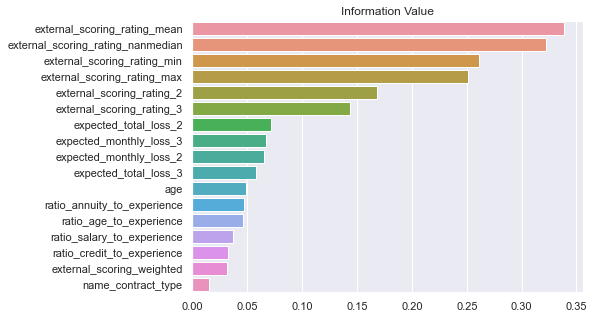

In [23]:
iv = iv[iv['IV'].round(2) > 0.01]

plt.figure(figsize=(7, 5))
sns.barplot(x=iv['IV'], y=iv['VAR_NAME'])
plt.title('Information Value')
plt.xlabel(''); plt.ylabel('')
plt.show()

## LightGBM

### Служебные инструменты

Объект KFold:

In [24]:
cv = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

Функция обновления словаря параметров найденными оптимальными значениями (и их вывод):

In [25]:
def update_params(params_search):
    optimal_params = params_search.max
    pprint(optimal_params)
    
    for k, v in optimal_params['params'].items():
        params[k] = v    
    params['max_depth'] = int(round(params['max_depth']))
    if 'min_child_weights' in params:
        params['min_child_weights'] = int(round(params['min_child_weights']))

Функция получения предсказаний от модели и их корреляционный анализ:

In [26]:
def calc_and_analyze_preds(X, y, X_test, models):
    model_names = [f'model_{i}' for i in range(1, N_SPLITS+1)]
    
    train_preds = pd.DataFrame(columns=model_names)
    test_preds = pd.DataFrame(columns=model_names)
    
    for i, model in enumerate(models, 1):
        model_name = f'model_{i}'
        if boost_model == 'XGB':
            train_preds[model_name] = model.predict(xgb.DMatrix(X))
            test_preds[model_name] = model.predict(xgb.DMatrix(X_test))
        else:
            train_preds[model_name] = model.predict_proba(X)[:, 1]
            test_preds[model_name] = model.predict_proba(X_test)[:, 1]
    
    train_preds['target'] = y
    
    comb_preds = pd.DataFrame(y, columns=['target'])
    comb_preds['mean'] = train_preds[model_names].mean(axis=1)
    comb_preds['gmean'] = train_preds[model_names].apply(gmean, axis=1)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(14, 10))
    axes = axes.flatten()

    for ax, preds, title in zip(axes[:2], [train_preds, test_preds], ['Train', 'Test']):
        sns.heatmap(preds[model_names].corr(), ax=ax, annot=True, linewidths=.5, cmap='GnBu')
        ax.set_title(title)
        ax.tick_params(axis='y', labelrotation=0)
    ax.yaxis.set_visible(False)

    target_corr = train_preds.corr()[['target']]
    sns.heatmap(target_corr[:-1], ax=axes[2], annot=True, linewidths=.5)
    axes[2].tick_params(axis='y', labelrotation=0)    
    
    comb_corr = comb_preds.corr()[['target']]
    sns.heatmap(comb_corr[1:], ax=axes[3], annot=True, linewidths=.5, cmap='viridis')
    axes[3].tick_params(axis='y', labelrotation=0)        
    # axes[3].axis("off")
    
    return train_preds, test_preds, comb_preds

Функция обучения моделей XGBoost и LightGBM с заданными параметрами (для оптимизации):

In [27]:
def boost_optimize_params(max_depth, min_child_weights, colsample_bytree):

    params["max_depth"] = int(round(max_depth))
    params["min_child_weights"] = int(round(min_child_weights))
    params["colsample_bytree"] = colsample_bytree

    if boost_model == 'XGB':
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            num_boost_round=N_ITERATIONS,
            verbose_eval=VERBOSE,
            maximize=True,
        )
        
        score = roc_auc_score(y_valid, model.predict(dvalid))
    
    elif boost_model == 'LGBM':  
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=VERBOSE,
            categorical_feature=cat_features
        )        
    
        score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

    print('\n')
    
    return score

### Поиск параметров и обучение классификатора

Параметры и преобразование данных для модели:

In [28]:
boost_model = 'LGBM'

params = {
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "learning_rate": 0.01,
    "thread_count": 6,
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
    "n_estimators": N_ITERATIONS,
    "seed": 27
}

for df in X, X_train, X_valid, X_test:
    df[cat_features] = df[cat_features].astype('category')

Оптимальные значения параметров:

In [29]:
pbounds = {
    "max_depth": (3, 8),
    "min_child_weights": (5, 500),
    "colsample_bytree": (0.3, 0.9)
}

lgb_params_search = BayesianOptimization(
    boost_optimize_params,
    pbounds=pbounds,
    random_state=SEED
)

lgb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)
clear_output(wait=True)

update_params(lgb_params_search)

{'params': {'colsample_bytree': 0.3551986056458608,
            'max_depth': 6.866804031515304,
            'min_child_weights': 5.2800525489629715},
 'target': 0.7367323108020991}


Кросс-валидация и метрики oof-предсказаний по фолдам:

In [30]:
lgb_estimators, lgb_oof_preds = boost_cross_validation(
    params=params, X=X, y=y, cv=cv, categorical=cat_features
)

Score by each fold: [0.74399, 0.72529, 0.73057, 0.72928, 0.71459]


Метрика oof-предсказаний в общем:

In [31]:
lgb_oof_score = roc_auc_score(y, lgb_oof_preds)
lgb_oof_score

0.7281452159696166

## Получение предсказаний, анализ и выбор

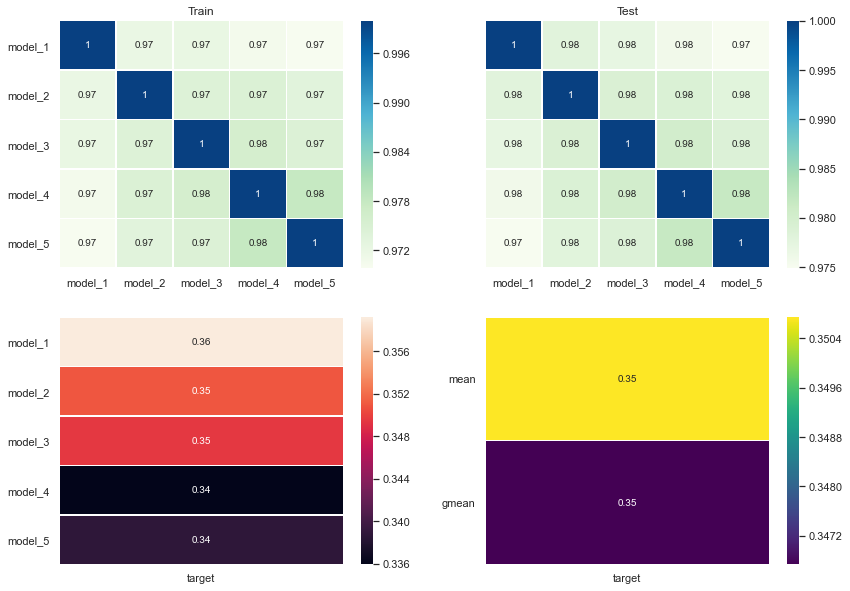

In [32]:
train_preds, test_preds, comb_preds = calc_and_analyze_preds(X, y, X_test, lgb_estimators)

Выводы:
 - все модели близко коррелируют друг с другом и практически одинаково - с целевым признаком;
 - среднее арифметическое и среднее геометрическое предсказаний моделей коррелируют также одинаково;
 - метрика oof-предсказаний в общем не выбивается в сравнении с её значениями на отдельных фолдах.
 
В качестве финального предсказания примем среднее арифметическое предсказаний на данных для теста.

## Сохранение результата

In [33]:
sample_submit = pd.read_csv('geekbrains-competitive-data-analysis/sample_submit.csv')
sample_submit.head(n=5)

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [34]:
sample_submit['TARGET'] = test_preds.mean(axis=1)
sample_submit.set_index('APPLICATION_NUMBER', inplace=True, drop=True)
sample_submit.head(n=5)

,TARGET
APPLICATION_NUMBER,
123724268,0.067549
123456549,0.241301
123428178,0.159637
123619984,0.084196
123671104,0.021426


In [35]:
sample_submit.to_csv('geekbrains-competitive-data-analysis/sample_submit42.csv')

# 0.73216